In [1]:
!pip install torchview

In [2]:

import torch  # PyTorch library, provides tensor computation and deep neural networks
import torchvision  # Package that provides access to popular datasets, model architectures, and image transformations for computer vision
from torchview import draw_graph  # Library for visualizing PyTorch computation graphs


import torch.nn as nn  # Provides classes to define and manipulate neural networks
import torch.nn.functional as F  # Contains functions that do not have any parameters, such as relu, tanh, etc.
import torch.optim as optim  # Package implementing various optimization algorithms - used to update the parameters of your network
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python
import numpy as np  # Library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays


In [33]:
n_epochs = 10 # Number of epochs to train the model
batch_size_train = 64 # Number of training examples utilized in one iteration
batch_size_test = 10000 # Number of test examples utilized in one iteration
learning_rate = 0.05 # Learning rate for the optimizer
momentum = 0.5 # Momentum for the optimizer
log_interval = 100 # Number of batches to wait before logging training status

random_seed = 1 # Random seed for reproducibility
torch.backends.cudnn.enabled = False # Disables cuDNN for reproducibility
torch.manual_seed(random_seed) # Sets the seed for generating random numbers

In [34]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,  # Loads the MNIST dataset and creates a DataLoader
                             transform=torchvision.transforms.Compose([   # Preprocessing the data
                               torchvision.transforms.ToTensor(),  # Converts the image to a tensor
                               torchvision.transforms.Normalize(     # Normalizes the image
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)   # Number of training examples utilized in one iteration, shuffles the data after every epoch

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

In [35]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [36]:
images_concat = torchvision.utils.make_grid(example_data[:25].view(-1,1, 28,28), nrow=5, value_range=(0,1))
torchvision.utils.save_image(images_concat/images_concat.max(), f"MNIST_full_dense.png")


![](MNIST_full_dense.png)

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 64)   # Fully connected layer with 784 input features and 64 output features
        self.fc2 = nn.Linear(64, 32)   # Fully connected layer with 64 input features and 32 output features
        self.fc3 = nn.Linear(32, 10)  # Fully connected layer with 32 input features and 10 output features

    def forward(self, x):
        x = x.view(-1, 784) # Reshapes the input tensor to a 1D tensor
        x = F.relu(self.fc1(x)) # Applies the rectified linear unit function to the output of the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [38]:
network = Net() # Instantiates the neural network
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) # Instantiates the optimizer
criterion = nn.CrossEntropyLoss() # Instantiates the loss function

In [39]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

52650


In [40]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [41]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensors
    output = network(data) # Forward pass: computes predicted outputs by passing inputs to the model
    loss = criterion(output, target)  # Computes the loss
    loss.backward() # Backward pass: computes gradient of the loss with respect to model parameters
    optimizer.step() # Updates the parameters of the model
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [42]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      print( criterion(output, target))
      test_loss += criterion(output, target).sum()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [43]:
test()
for epoch in range(1, n_epochs + 1):
    if epoch%3==0 and epoch>0:
        learning_rate = learning_rate/2
        for g in optimizer.param_groups:
            g['lr'] = learning_rate
    train(epoch)
    test()


tensor(2.3160)

Test set: Avg. loss: 2.3160, Accuracy: 944/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.280398
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.623800
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.315621
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.188172
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.240374
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.176366
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.118032
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.133630
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.266837
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.152032
tensor(0.1568)

Test set: Avg. loss: 0.1568, Accuracy: 9507/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.291509
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.080876
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.170139
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.098323
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.079740
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.131506
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.136253
Train Epoch: 2 [44

Text(0, 0.5, 'Cross-Entropy')

<Figure size 640x480 with 0 Axes>

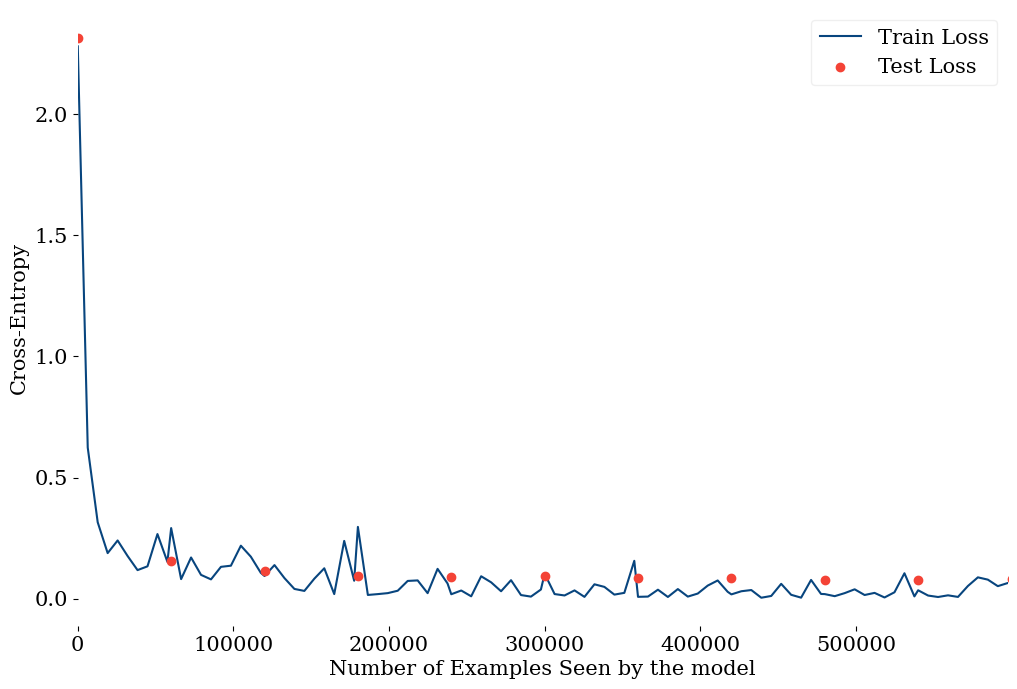

In [51]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(train_counter, train_losses, color='#08457E')
plt.scatter(test_counter, test_losses, color='#F44336',zorder=+100)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlim([0, max(train_counter)])
plt.xlabel('Number of Examples Seen by the model')
plt.ylabel('Cross-Entropy')



In [53]:

batch_size = 64
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(network,
                         input_size=(batch_size, 784),
                         device='cpu',
                        #  graph_dir='LR',
                         filename='densemnist',
                        save_graph=True)

model_graph.visual_graph.render(format='png')

'densemnist.png'

In [45]:
example_targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [46]:
example_data

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [50]:
network(example_data)[0]

tensor([ -0.9036,  -1.4950,   5.4483,   5.5263,  -4.0616,  -5.2461, -14.2352,
         15.5632,   1.1705,   2.3585], grad_fn=<SelectBackward0>)